# DAT257x: Reinforcement Learning Explained

## Lab 7: Policy Gradient

### Exercise 7.1: REINFORCE

This assignment features the Cartpole domain which tasks the agent with balancing a pole affixed to a movable cart. The agent employs two discrete actions which apply force to the cart. Episodes provide +1 reward for each step in which the pole has not fallen over, up to a maximum of 200 steps. 


## Objectives
* Understand and implement REINFORCE loss function: $\nabla_\theta J(\theta)=\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) R$
* Implement psuedo-labels needed to train the policy network
* Verify that your REINFORCE implementation solves Cartpole

## Success Criterion
When correctly implemented, the REINFORCE algorithm should be able to balance the poll for 200 steps within a few hundred episodes of learning. However, it's recommended to run the algorithm several times, as even a correct algorithm may fail to learn. 

In [21]:
import cntk as C
import numpy as np
import gym

import sys
if "../" not in sys.path:
    sys.path.append("../") 
    
from lib.running_variance import RunningVariance
from itertools import count
from lib import plotting

np.random.seed(123)
C.cntk_py.set_fixed_random_seed(123)
C.cntk_py.force_deterministic_algorithms()

Now that we've finished with imports we need to create the CartPole environment. (See https://gym.openai.com/envs/CartPole-v0/) for more details. Additionally, we'll save the size of the state and action spaces, and define the number of hidden units in our network as well as how often (in episodes) the Reinforce update is applied. These parameters don't need to be changed, but you can try varying the hidden_size and update_frequency and see how learning is affected.

In [22]:
env = gym.make('CartPole-v0')

state_dim = env.observation_space.shape[0] # Dimension of state space
action_count = env.action_space.n # Number of actions
hidden_size = 128 # Number of hidden units
update_frequency = 20

Next we will define the policy network.

In [23]:
# The policy network maps an observation to a probability of taking action 0 or 1.
observations = C.sequence.input_variable(state_dim, np.float32, name="obs")
W1 = C.parameter(shape=(state_dim, hidden_size), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=hidden_size, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)
W2 = C.parameter(shape=(hidden_size, action_count), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=action_count, name="b2")
layer2 = C.times(layer1, W2) + b2
output = C.sigmoid(layer2, name="output")

Now you must define the loss function for training the policy network. 

- Recall that the desired loss function is: $\frac{1}{m}\sum_1^m \nabla_\theta \log \pi_\theta(a_t|s_t) R$. 

- Label is a variable corresponding to $a_t$, the action the policy selected. 

- output is the policy network that maps an observation to a probability of taking an action.

- And return_weight is a scalar that will cointain the return $R$.

The current loss function is incorrect and will need to be modified.

In [24]:
# Label will tell the network what action it should have taken.
label = C.sequence.input_variable(1, np.float32, name="label")
# return_weight is a scalar containing the discounted return. It will scale the PG loss.
return_weight = C.sequence.input_variable(1, np.float32, name="weight")

# TODO 1
# Modify loss function to implement policy gradient loss.
# The loss should encourage the network's output to become more like the provided label, 
# when the Return is positive and less like the label when the Return is negative.
# PG_Loss = mean( log(probability(a|s)) * R(s))
# Hint: C.log() and C.square() may come in handy. 
loss = -C.reduce_mean(C.log(C.square(label - output) + 1e-4) * return_weight, axis=0, name='loss') ## modify this loss function

Next we build the optimizer that contains hyperparameters for training the policy network. Also we create a buffer which will accumulate gradients throughout update_frequency episodes.

In [25]:
# Build the optimizer
lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
m_schedule = C.momentum_schedule(0.99)
vm_schedule = C.momentum_schedule(0.999)
optimizer = C.adam([W1, W2], lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)

# Create a buffer to manually accumulate gradients
gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

This is a helper function to discount rewards.

In [26]:
def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

Here is the main training loop. The only part that needs to be modified is the code for choosing a psuedo-label. Remember this pseudo-label should encourage the agent to increase the probability of the action it selected.

In [27]:
running_variance = RunningVariance()
reward_sum = 0

max_number_of_episodes = 500

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(max_number_of_episodes),
    episode_rewards=np.zeros(max_number_of_episodes),
    episode_running_variance=np.zeros(max_number_of_episodes))   
    
for episode_number in range(max_number_of_episodes):
    states, rewards, labels = [],[],[]
    done = False
    
    observation = env.reset()
    t = 1
    while not done:
        
        state = np.reshape(observation, [1, state_dim]).astype(np.float32)
        states.append(state)

        # Run the policy network and get an action to take.
        prob = output.eval(arguments={observations: state})[0][0][0]
        # Sample from the bernoulli output distribution to get a discrete action
        action = 1 if np.random.uniform() < prob else 0

        # TODO 2
        # Modify saved labels to encourage the network to increase
        # the probability of the chosen action. This label will be used
        # in the loss function above.
        
        y = 1 if action == 0 else 0 # modify 1 to create a "fake label" or pseudo label
        labels.append(y)
    
        # step the environment and get new measurements
        observation, reward, done, _ = env.step(action)

        # Uncomment this line to render the environment
        # env.render()

        reward_sum += float(reward)

        # Record reward (has to be done after we call step() to get reward for previous action)
        rewards.append(float(reward))
                    
        stats.episode_rewards[episode_number] += reward
        stats.episode_lengths[episode_number] = t
        
        t += 1

    # Stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(states)
    epl = np.vstack(labels).astype(np.float32)
    epr = np.vstack(rewards).astype(np.float32)

    # Compute the discounted reward backwards through time.
    discounted_epr = discount_rewards(epr)

    # Keep a running estimate over the variance of of the discounted rewards
    for r in discounted_epr:    
        running_variance.add(r[0])

    # Forward pass
    arguments = {observations: epx, label: epl, return_weight: discounted_epr}
    state, outputs_map = loss.forward(arguments, outputs=loss.outputs,
                                      keep_for_backward=loss.outputs)

    # Backward pass
    root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
    vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

    for var, grad in vargrads_map.items():
        gradBuffer[var.name] += grad

    # Only update every 20 episodes to reduce noise
    if episode_number % update_frequency == 0:
        grads = {W1: gradBuffer['W1'].astype(np.float32),
                 W2: gradBuffer['W2'].astype(np.float32)}
        updated = optimizer.update(grads, update_frequency)

        # reset the gradBuffer
        gradBuffer = dict((var.name, np.zeros(shape=var.shape))
                          for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

        print('Episode: %d. Average reward for episode %f. Variance %f' % (episode_number, reward_sum / update_frequency, running_variance.get_variance()))

        reward_sum = 0

    stats.episode_running_variance[episode_number] = running_variance.get_variance()
    


Episode: 0. Average reward for episode 1.350000. Variance 57.000417
Episode: 20. Average reward for episode 45.300000. Variance 399.838756
Episode: 40. Average reward for episode 59.850000. Variance 552.217083
Episode: 60. Average reward for episode 66.550000. Variance 520.339400
Episode: 80. Average reward for episode 76.350000. Variance 625.303357
Episode: 100. Average reward for episode 90.800000. Variance 772.463683
Episode: 120. Average reward for episode 98.750000. Variance 944.875959
Episode: 140. Average reward for episode 142.750000. Variance 1379.597891
Episode: 160. Average reward for episode 178.500000. Variance 1905.351083
Episode: 180. Average reward for episode 189.350000. Variance 2204.388461
Episode: 200. Average reward for episode 196.750000. Variance 2394.881270
Episode: 220. Average reward for episode 195.050000. Variance 2497.759999
Episode: 240. Average reward for episode 189.150000. Variance 2546.603655
Episode: 260. Average reward for episode 182.350000. Varianc

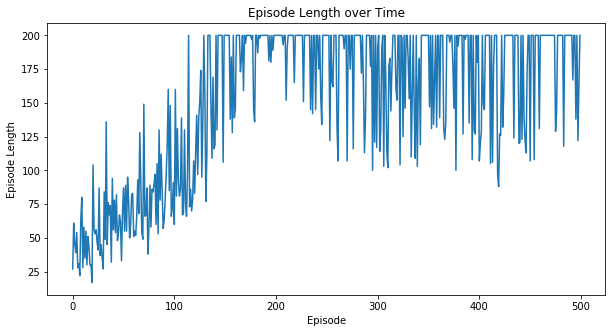

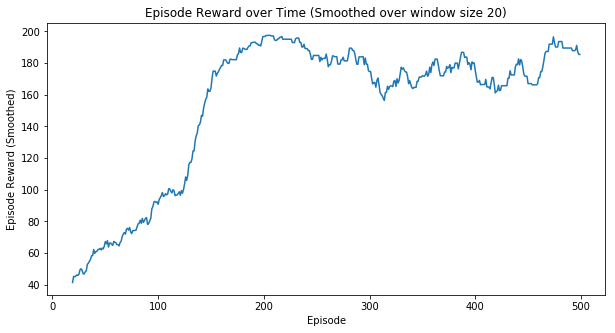

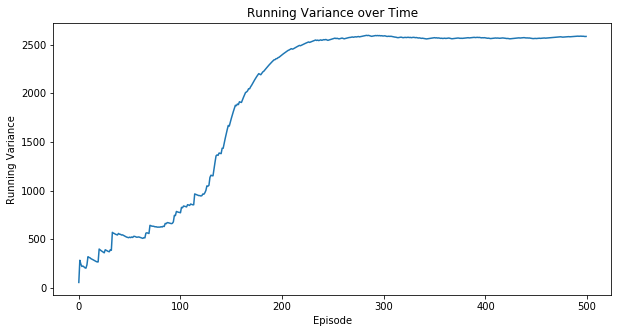

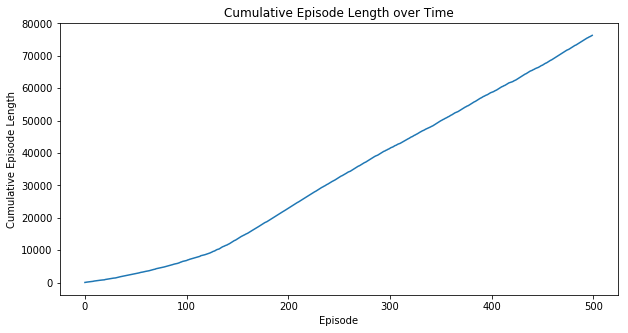

(<matplotlib.figure.Figure at 0x7fe0f0646c50>,
 <matplotlib.figure.Figure at 0x7fe0f0358320>)

In [28]:
plotting.plot_pgresults(stats)